In [3]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import NeighborSampler as RawNeighborSampler

EPS = 1e-15

dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]


class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


train_loader = NeighborSampler(data.edge_index, sizes=[10, 10], batch_size=256,
                               shuffle=True, num_nodes=data.num_nodes)


class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)


def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

losses=[]
accs_1=[]
accs_2=[]
for epoch in range(1, 51):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    losses.append(loss)
    accs_1.append(val_acc)
    accs_2.append(test_acc)

Epoch: 001, Loss: 1.3867, Val: 0.3860, Test: 0.3490
Epoch: 002, Loss: 1.3108, Val: 0.5700, Test: 0.5330
Epoch: 003, Loss: 1.1688, Val: 0.6500, Test: 0.5960
Epoch: 004, Loss: 1.0973, Val: 0.6520, Test: 0.6540
Epoch: 005, Loss: 1.0824, Val: 0.6860, Test: 0.6790
Epoch: 006, Loss: 1.0597, Val: 0.7020, Test: 0.7000
Epoch: 007, Loss: 1.0303, Val: 0.7140, Test: 0.7080
Epoch: 008, Loss: 1.0087, Val: 0.7220, Test: 0.6960
Epoch: 009, Loss: 0.9863, Val: 0.7180, Test: 0.7080
Epoch: 010, Loss: 0.9885, Val: 0.7340, Test: 0.7260
Epoch: 011, Loss: 0.9911, Val: 0.7320, Test: 0.7370
Epoch: 012, Loss: 0.9623, Val: 0.7320, Test: 0.7350
Epoch: 013, Loss: 0.9761, Val: 0.7360, Test: 0.7390
Epoch: 014, Loss: 0.9631, Val: 0.7220, Test: 0.7410
Epoch: 015, Loss: 0.9596, Val: 0.7140, Test: 0.7450
Epoch: 016, Loss: 0.9628, Val: 0.7280, Test: 0.7520
Epoch: 017, Loss: 0.9450, Val: 0.7280, Test: 0.7560
Epoch: 018, Loss: 0.9426, Val: 0.7160, Test: 0.7510
Epoch: 019, Loss: 0.9421, Val: 0.7140, Test: 0.7490
Epoch: 020, 

In [5]:
from matplotlib import pyplot as plt

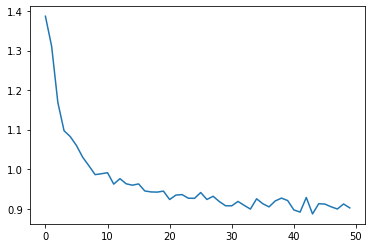

In [8]:
plt.plot(losses)

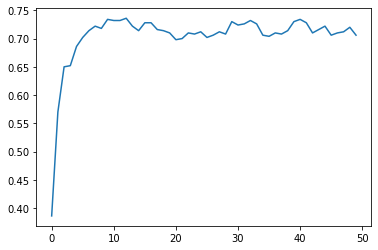

In [9]:
plt.plot(accs_1)

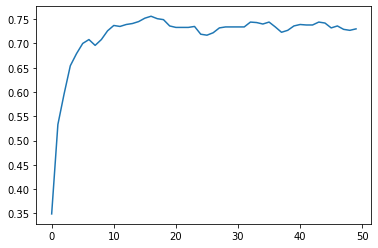

In [10]:
plt.plot(accs_2)